# Import dependencies

In [ ]:
!pip install opendatasets
!pip install torch torchvision torchaudio
!pip install tqdm
!pip install matplotlib

In [35]:
import os
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import opendatasets as od

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image

# Download dataset

In [5]:
dataset_url = "https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset"

os.makedirs('data', exist_ok=True)
od.download(dataset_url, data_dir='data')

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.82G/1.82G [02:33<00:00, 12.8MB/s]


# Load dataset

In [36]:
TRAIN_DIR = os.path.join('data', 'stanford-cars-dataset')

In [37]:
batch_size = 128
image_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [38]:
transforms = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

train_dataset = ImageFolder(TRAIN_DIR, transform=transforms)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

# Display the dataset

In [106]:
def denormalize(img_tensors, device=None):
    # Ensure mean and std tensors are on the same device as img_tensors
    mean = torch.tensor(stats[0], device=img_tensors.device).view(3, 1, 1)
    std = torch.tensor(stats[1], device=img_tensors.device).view(3, 1, 1)
    return img_tensors * std + mean

In [107]:
def show_images(images, nmax=32):
    _, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])

    # Denormalize images
    denormalized_images = denormalize(images.detach()[:nmax])
    
    # Convert to grid
    grid_img = make_grid(denormalized_images, nrow=8).permute(1, 2, 0).clamp(0, 1)
    
    ax.imshow(grid_img.cpu().numpy())
    plt.show()

In [108]:
def show_batch(dataloader, nmax=32):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

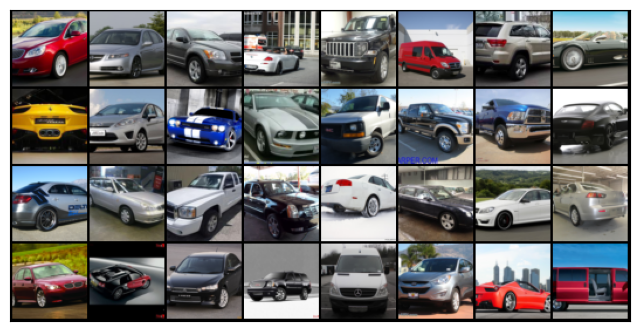

In [109]:
show_batch(train_dataloader)

# Using a GPU

In [42]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [43]:
device = get_default_device()
device

device(type='cuda')

In [44]:
train_dataloader = DeviceDataLoader(train_dataloader, device)

# Designing the networks

## Discriminator Network

In [86]:
def create_discriminator():
    return nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid() # output range: (0; 1)
)

In [45]:
discriminator = create_discriminator()

In [46]:
discriminator = to_device(discriminator, device)
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

## Generator Network

In [85]:
latent_size = 128

def create_generator():
    return nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh() # range: (-1; 1)
    # out: 3 x 64 x 64
)

In [ ]:
generator = create_generator()

In [48]:
generator = to_device(generator, device)
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

# Training

## Discriminator training

In [49]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through the discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass the fake images through the discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward() 
    opt_d.step()

    return loss.item(), real_score, fake_score

## Generator training

In [50]:
def train_generator(opt_g):
    # Clear the generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [51]:
sample_dir = 'generated-images'
os.makedirs(sample_dir, exist_ok=True)

In [57]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4}.png'.format(index)
    save_image(denormalize(fake_images, device), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)

    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0).clamp(0, 1))

In [58]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


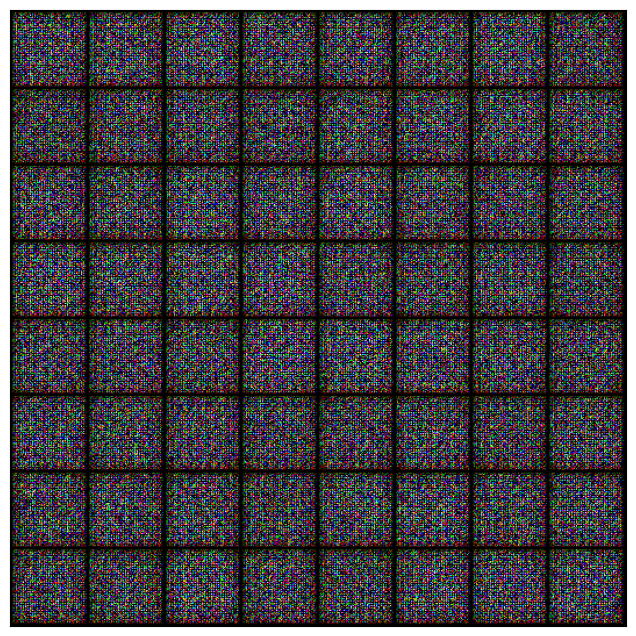

In [59]:
save_samples(0, fixed_latent)

## Full training loop

In [60]:
from tqdm.notebook import tqdm

In [61]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dataloader): # Shows progress bar
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [64]:
lr = 0.0002
epochs = 100

In [65]:
history = fit(epochs, lr)

  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 4.6006, loss_d: 0.2467, real_score: 0.8554, fake_score: 0.0733
Saving generated-images-0001.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 6.6369, loss_d: 0.3433, real_score: 0.7693, fake_score: 0.0054
Saving generated-images-0002.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 3.5880, loss_d: 0.3579, real_score: 0.8462, fake_score: 0.1511
Saving generated-images-0003.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 4.1671, loss_d: 0.3228, real_score: 0.8382, fake_score: 0.1075
Saving generated-images-0004.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 2.7524, loss_d: 0.4690, real_score: 0.7146, fake_score: 0.0586
Saving generated-images-0005.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 4.2087, loss_d: 0.2669, real_score: 0.9705, fake_score: 0.1811
Saving generated-images-0006.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 4.2653, loss_d: 0.3283, real_score: 0.7778, fake_score: 0.0336
Saving generated-images-0007.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 4.7409, loss_d: 0.2804, real_score: 0.9530, fake_score: 0.1880
Saving generated-images-0008.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 3.2006, loss_d: 0.2530, real_score: 0.9028, fake_score: 0.1190
Saving generated-images-0009.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 3.5615, loss_d: 0.3235, real_score: 0.7908, fake_score: 0.0602
Saving generated-images-0010.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 3.8353, loss_d: 1.9643, real_score: 0.2313, fake_score: 0.0010
Saving generated-images-0011.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 6.5626, loss_d: 0.4641, real_score: 0.9365, fake_score: 0.2898
Saving generated-images-0012.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 0.6517, loss_d: 0.9932, real_score: 0.4664, fake_score: 0.0023
Saving generated-images-0013.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 9.2317, loss_d: 1.4593, real_score: 0.9732, fake_score: 0.6802
Saving generated-images-0014.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.3052, loss_d: 0.4053, real_score: 0.8191, fake_score: 0.1461
Saving generated-images-0015.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 4.2299, loss_d: 0.2683, real_score: 0.8915, fake_score: 0.1174
Saving generated-images-0016.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 4.1289, loss_d: 0.2798, real_score: 0.8849, fake_score: 0.1258
Saving generated-images-0017.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 5.8939, loss_d: 0.2983, real_score: 0.9203, fake_score: 0.1658
Saving generated-images-0018.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.0474, loss_d: 0.1729, real_score: 0.9075, fake_score: 0.0611
Saving generated-images-0019.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 3.5362, loss_d: 0.3120, real_score: 0.8166, fake_score: 0.0720
Saving generated-images-0020.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 1.9806, loss_d: 0.4554, real_score: 0.7268, fake_score: 0.0491
Saving generated-images-0021.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 4.0965, loss_d: 0.1985, real_score: 0.9131, fake_score: 0.0897
Saving generated-images-0022.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 4.8397, loss_d: 0.4321, real_score: 0.7172, fake_score: 0.0198
Saving generated-images-0023.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 3.4925, loss_d: 0.3411, real_score: 0.7854, fake_score: 0.0519
Saving generated-images-0024.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 2.2344, loss_d: 0.6154, real_score: 0.6200, fake_score: 0.0151
Saving generated-images-0025.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 3.1212, loss_d: 1.1109, real_score: 0.4241, fake_score: 0.0013
Saving generated-images-0026.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 11.1199, loss_d: 8.7468, real_score: 1.0000, fake_score: 0.9987
Saving generated-images-0027.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 3.3891, loss_d: 0.4516, real_score: 0.6898, fake_score: 0.0242
Saving generated-images-0028.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 4.8143, loss_d: 0.2828, real_score: 0.7894, fake_score: 0.0168
Saving generated-images-0029.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.6365, loss_d: 0.1539, real_score: 0.9415, fake_score: 0.0833
Saving generated-images-0030.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 3.3848, loss_d: 0.2410, real_score: 0.8694, fake_score: 0.0712
Saving generated-images-0031.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 2.4143, loss_d: 0.4727, real_score: 0.8021, fake_score: 0.1674
Saving generated-images-0032.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 7.3055, loss_d: 3.5782, real_score: 0.9979, fake_score: 0.9109
Saving generated-images-0033.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 5.9761, loss_d: 0.5818, real_score: 0.9887, fake_score: 0.3804
Saving generated-images-0034.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 2.3955, loss_d: 0.3223, real_score: 0.8413, fake_score: 0.1098
Saving generated-images-0035.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 2.6598, loss_d: 1.3898, real_score: 0.3897, fake_score: 0.0097
Saving generated-images-0036.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 3.0603, loss_d: 0.3292, real_score: 0.8193, fake_score: 0.0912
Saving generated-images-0037.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 4.8286, loss_d: 0.3432, real_score: 0.9739, fake_score: 0.2403
Saving generated-images-0038.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 2.8389, loss_d: 0.2585, real_score: 0.8709, fake_score: 0.0924
Saving generated-images-0039.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.9547, loss_d: 0.1395, real_score: 0.8964, fake_score: 0.0205
Saving generated-images-0040.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 2.5295, loss_d: 0.1950, real_score: 0.9419, fake_score: 0.1126
Saving generated-images-0041.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 4.6960, loss_d: 0.0755, real_score: 0.9733, fake_score: 0.0451
Saving generated-images-0042.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 2.0228, loss_d: 0.2685, real_score: 0.8135, fake_score: 0.0429
Saving generated-images-0043.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 3.8097, loss_d: 0.1098, real_score: 0.9558, fake_score: 0.0592
Saving generated-images-0044.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 4.5833, loss_d: 0.1468, real_score: 0.9093, fake_score: 0.0391
Saving generated-images-0045.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 4.9722, loss_d: 0.3281, real_score: 0.9250, fake_score: 0.1862
Saving generated-images-0046.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 5.0060, loss_d: 0.8581, real_score: 0.8690, fake_score: 0.4004
Saving generated-images-0047.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 2.9523, loss_d: 0.3604, real_score: 0.8563, fake_score: 0.1592
Saving generated-images-0048.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 1.9906, loss_d: 0.3063, real_score: 0.8182, fake_score: 0.0690
Saving generated-images-0049.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 4.4410, loss_d: 0.1465, real_score: 0.9485, fake_score: 0.0821
Saving generated-images-0050.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 3.1420, loss_d: 0.2264, real_score: 0.8621, fake_score: 0.0466
Saving generated-images-0051.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 2.2432, loss_d: 0.1901, real_score: 0.8809, fake_score: 0.0340
Saving generated-images-0052.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 1.7234, loss_d: 0.9749, real_score: 0.4856, fake_score: 0.0276
Saving generated-images-0053.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 4.4273, loss_d: 0.1268, real_score: 0.9182, fake_score: 0.0334
Saving generated-images-0054.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 3.8933, loss_d: 0.0807, real_score: 0.9684, fake_score: 0.0452
Saving generated-images-0055.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 4.2319, loss_d: 0.2290, real_score: 0.9224, fake_score: 0.1209
Saving generated-images-0056.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 4.9581, loss_d: 0.1061, real_score: 0.9348, fake_score: 0.0340
Saving generated-images-0057.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 5.5233, loss_d: 0.1305, real_score: 0.9833, fake_score: 0.1000
Saving generated-images-0058.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 6.0145, loss_d: 0.4037, real_score: 0.9843, fake_score: 0.2863
Saving generated-images-0059.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 3.6797, loss_d: 0.1164, real_score: 0.9432, fake_score: 0.0510
Saving generated-images-0060.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 2.3700, loss_d: 0.7047, real_score: 0.5710, fake_score: 0.0471
Saving generated-images-0061.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 3.3723, loss_d: 0.1916, real_score: 0.9128, fake_score: 0.0803
Saving generated-images-0062.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 3.4088, loss_d: 1.5788, real_score: 0.9036, fake_score: 0.6074
Saving generated-images-0063.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 2.5284, loss_d: 0.2174, real_score: 0.8407, fake_score: 0.0222
Saving generated-images-0064.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 2.8995, loss_d: 0.2217, real_score: 0.8277, fake_score: 0.0155
Saving generated-images-0065.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 2.2638, loss_d: 0.3204, real_score: 0.7490, fake_score: 0.0032
Saving generated-images-0066.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 2.5958, loss_d: 0.1436, real_score: 0.9073, fake_score: 0.0343
Saving generated-images-0067.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.2039, loss_d: 0.1616, real_score: 0.9115, fake_score: 0.0572
Saving generated-images-0068.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 4.3567, loss_d: 0.1967, real_score: 0.9234, fake_score: 0.0969
Saving generated-images-0069.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 4.5286, loss_d: 0.1190, real_score: 0.9847, fake_score: 0.0934
Saving generated-images-0070.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 4.9305, loss_d: 1.2618, real_score: 0.9523, fake_score: 0.6036
Saving generated-images-0071.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.2375, loss_d: 0.1937, real_score: 0.9087, fake_score: 0.0752
Saving generated-images-0072.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 3.3695, loss_d: 0.1017, real_score: 0.9533, fake_score: 0.0468
Saving generated-images-0073.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 4.5638, loss_d: 0.0648, real_score: 0.9658, fake_score: 0.0279
Saving generated-images-0074.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 4.1659, loss_d: 0.0635, real_score: 0.9785, fake_score: 0.0393
Saving generated-images-0075.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 4.8629, loss_d: 0.0791, real_score: 0.9587, fake_score: 0.0342
Saving generated-images-0076.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.0330, loss_d: 1.5952, real_score: 0.8910, fake_score: 0.6487
Saving generated-images-0077.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 4.0169, loss_d: 0.1116, real_score: 0.9495, fake_score: 0.0519
Saving generated-images-0078.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 4.6566, loss_d: 0.0578, real_score: 0.9710, fake_score: 0.0268
Saving generated-images-0079.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 4.6652, loss_d: 0.0499, real_score: 0.9719, fake_score: 0.0200
Saving generated-images-0080.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 2.0341, loss_d: 0.6643, real_score: 0.8135, fake_score: 0.3172
Saving generated-images-0081.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 3.7799, loss_d: 0.1303, real_score: 0.9121, fake_score: 0.0301
Saving generated-images-0082.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 4.0432, loss_d: 0.0934, real_score: 0.9726, fake_score: 0.0604
Saving generated-images-0083.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 2.4418, loss_d: 0.4819, real_score: 0.7323, fake_score: 0.1070
Saving generated-images-0084.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 3.8523, loss_d: 0.0745, real_score: 0.9679, fake_score: 0.0382
Saving generated-images-0085.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.4262, loss_d: 0.0672, real_score: 0.9725, fake_score: 0.0367
Saving generated-images-0086.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 2.9102, loss_d: 0.5388, real_score: 0.7161, fake_score: 0.1138
Saving generated-images-0087.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 3.7300, loss_d: 0.0978, real_score: 0.9649, fake_score: 0.0538
Saving generated-images-0088.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 3.1634, loss_d: 0.0987, real_score: 0.9282, fake_score: 0.0193
Saving generated-images-0089.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 4.6336, loss_d: 0.0990, real_score: 0.9543, fake_score: 0.0459
Saving generated-images-0090.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 2.8416, loss_d: 0.1295, real_score: 0.8987, fake_score: 0.0151
Saving generated-images-0091.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 4.3028, loss_d: 0.0572, real_score: 0.9753, fake_score: 0.0298
Saving generated-images-0092.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 4.4848, loss_d: 0.0383, real_score: 0.9916, fake_score: 0.0287
Saving generated-images-0093.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 4.8854, loss_d: 0.0648, real_score: 0.9855, fake_score: 0.0458
Saving generated-images-0094.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 6.3851, loss_d: 0.0404, real_score: 0.9684, fake_score: 0.0076
Saving generated-images-0095.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 2.6024, loss_d: 0.2823, real_score: 0.8624, fake_score: 0.0699
Saving generated-images-0096.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 4.4926, loss_d: 0.0608, real_score: 0.9722, fake_score: 0.0309
Saving generated-images-0097.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 3.4372, loss_d: 0.0888, real_score: 0.9311, fake_score: 0.0151
Saving generated-images-0098.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 3.1252, loss_d: 0.3827, real_score: 0.8399, fake_score: 0.1576
Saving generated-images-0099.png


  0%|          | 0/127 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 2.9304, loss_d: 0.1483, real_score: 0.8983, fake_score: 0.0300
Saving generated-images-0100.png


In [66]:
losses_g, losses_d, real_scores, fake_scores = history

## View the generated images

In [67]:
from IPython.display import Image

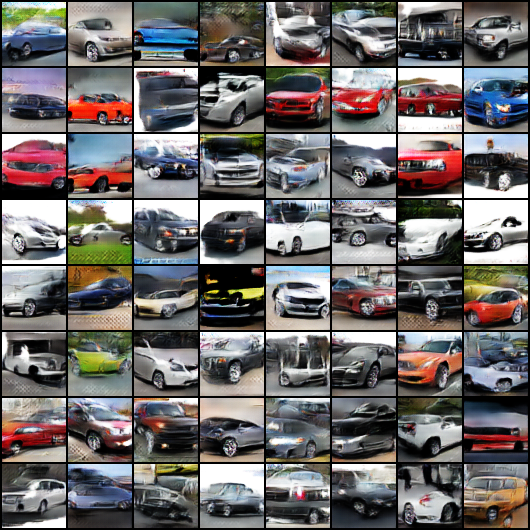

In [68]:
Image(os.path.join('generated-images', 'generated-images-0100.png'))

## Visualize the training process

In [69]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


# Plot performance

Text(0.5, 1.0, 'Losses')

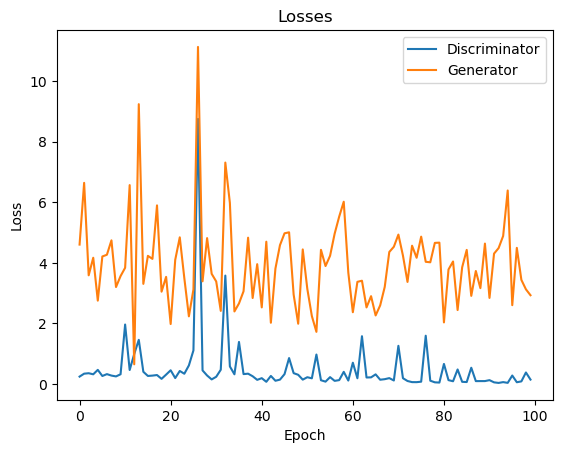

In [72]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')

Text(0.5, 1.0, 'Scores')

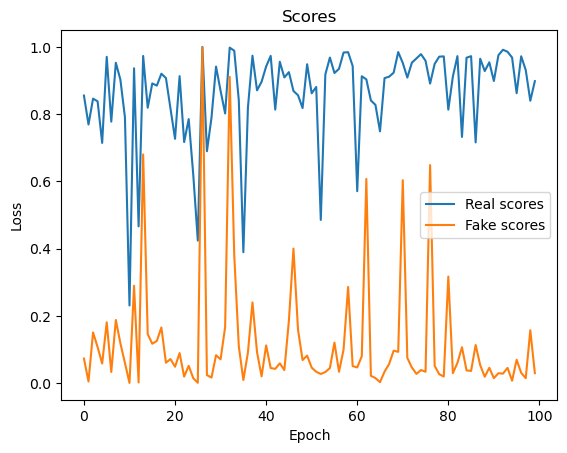

In [73]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Real scores', 'Fake scores'])
plt.title('Scores')

# Saving the models

In [74]:
os.makedirs('models', exist_ok=True)

In [76]:
discri_path = os.path.join('models', 'discriminator.pth')
gen_path = os.path.join('models', 'generator.pth')

In [77]:
torch.save(discriminator.state_dict(), discri_path)
torch.save(generator.state_dict(), gen_path)

In [110]:
# Create new model instances
new_discriminator = create_discriminator()
new_generator = create_generator()

# Load to the device (GPU)
new_discriminator = to_device(new_discriminator, device)
new_generator = to_device(new_generator, device)

# Load the state dictionaries from the files
discriminator_state_dict = torch.load(discri_path)
generator_state_dict = torch.load(gen_path)

# Load the state dictionaries into the models
new_discriminator.load_state_dict(discriminator_state_dict)
new_generator.load_state_dict(generator_state_dict)

<All keys matched successfully>

In [111]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

images = new_generator(fixed_latent)

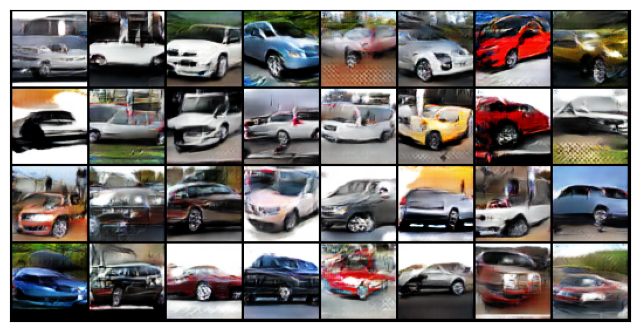

In [112]:
show_images(images)